<style>
.noborder td, .noborder th, .noborder table {
    border: none !important;
}
</style>

<table id="top" class="noborder" style="width:100%; border-collapse:collapse;">
  <tr>
    <td style="text-align:left; width:33%;">
      <a href="./05_predicting_mental_state.ipynb" title="Predicting Mental State">&lt; Previous</a>
    </td>
    <td style="text-align:center; width:33%;">06</td>
    <td style="text-align:right; width:33%;">
      <a href="./07_predicting_stress_level.ipynb" title="Prediciting Stress Level">Next &gt;</a>
    </td>
  </tr>
</table>

# Predicting Sleep
---

Import libraries:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import joblib

---

## Import cleaned data parquet file

Import the cleaned data that was the output of the 1st notebook

In [2]:
df = pd.read_parquet("../data/mental_health_social_media_dataset_cleaned.parquet")

---
## Select Features

In [3]:
# List numeric columns
numeric_features = [
    "age",
    "daily_screen_time_min",
    "social_media_time_min",
    "physical_activity_min",
    "interaction_negative_ratio",
    "stress_level",
    "mood_level",
    "anxiety_level"
]

# List categorical columns
categorical_features = ["gender", "platform", "mental_state"]

# List all features
features = numeric_features + categorical_features

# List target variable
target = "sleep_hours"

# Select features and target variable
data = df[features + [target]].copy()

---
## Train/Test split the data

In [4]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    data[features], data[target],
    test_size=0.2, random_state=42
)

---
## Build the pipeline

Category columns were encoded to create separate boolean columns for each of the individual options

Numerical columns were scaled to stop larger values influencing outcomes

In [7]:
# Define the column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
    ]
)

# Create the pipeline
pipeline = Pipeline(steps=[
    ("prep", preprocessor),
    ("model", LinearRegression())
])

---
## Fit pipeline

In [8]:
# Fit the pipeline to the training data
pipeline.fit(X_train, y_train)

,steps,"[('prep', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


---
## Evaluate the results

In [9]:
# Make predictions on the test set
y_pred = pipeline.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Print the evaluation metrics
print("MAE:", mae)
print("RMSE:", rmse)
print("R²:", r2)

MAE: 0.025351266338742996
RMSE: 0.02876856835844466
R²: 0.9970373626290665


MAE: 0.025 - On average, the model is only off by 0.025 hours (~1.5 minutes) which is incredibly accurate.

RMSE: 0.028 - Errors are incredibly small.

R²: 0.997 - The model explains 99.7% of the variance in sleep hours.


Create scatter chart to compare actaul with predicted:

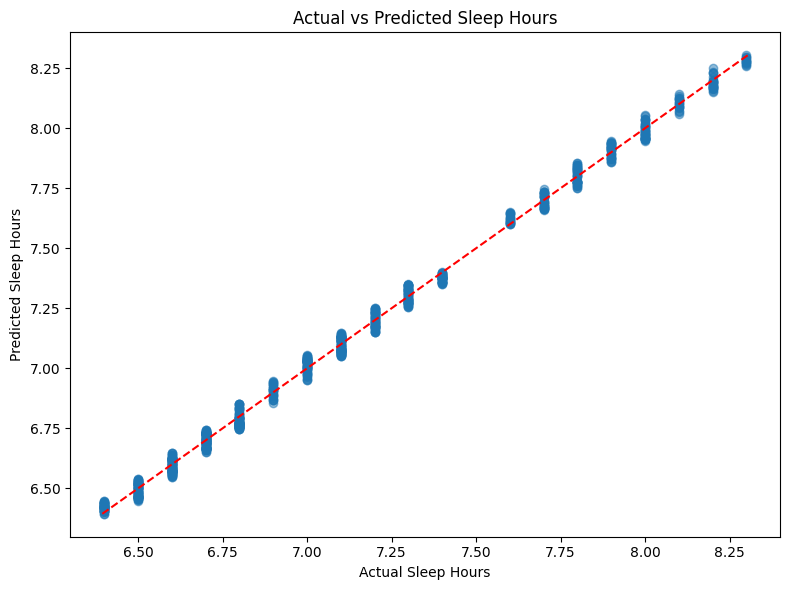

In [14]:
fig = plt.figure(figsize=(8, 6))

# Scatter plot of actual vs predicted sleep hours
plt.scatter(y_test, y_pred, alpha=0.5)

# Add labels and title
plt.xlabel("Actual Sleep Hours")
plt.ylabel("Predicted Sleep Hours")
plt.title("Actual vs Predicted Sleep Hours")

# Add a diagonal line for reference
max_val = max(y_test.max(), y_pred.max())
min_val = min(y_test.min(), y_pred.min())
plt.plot([min_val, max_val], [min_val, max_val], color="red", linestyle="--")

# Show and save the plot
plt.tight_layout()
plt.savefig('../charts/predicting_sleep_linear_regression_scatter.png')
plt.show()

View the exported png [here](../charts/predicting_sleep_linear_regression_scatter.png)

What the plot shows:
- The points form an almost perfectly straight diagonal band.
- There is very little vertical spread, meaning predictions hardly deviate from actual values.
- There is no curve, pattern, or clustering that would suggest systematic error.


Add a residual chart:

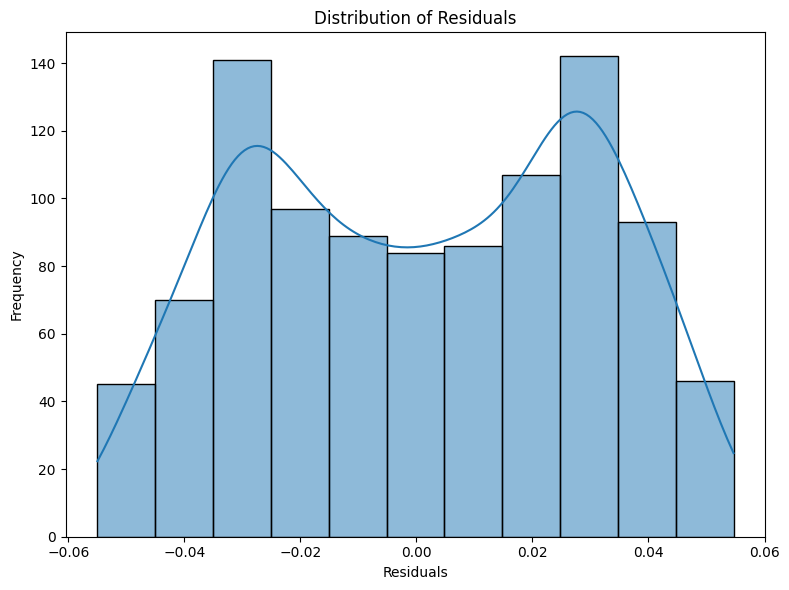

In [15]:
# Calculate residuals
residuals = y_test - y_pred

# Plot the distribution of residuals
plt.figure(figsize=(8, 6))

# Histogram of residuals
sns.histplot(residuals, kde=True)

# Add labels and title
plt.title("Distribution of Residuals")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.tight_layout()

# Show and save the plot
plt.savefig('../charts/predicting_sleep_linear_regression_residuals.png')
plt.show()

View the exported png [here](../charts/predicting_sleep_linear_regression_residuals.png)

The model is very accurate and not biased in one direction and the distribution is mostly symmetric with no signs of under or over prediction.

---
## Save the model

In [16]:
# save the model
joblib.dump(pipeline, '../models/predicting_sleep_linear_regression_model.pkl')

['../models/predicting_sleep_linear_regression_model.pkl']

---
## Run the model on unseen data

I am going to use the persona data created on the cluster notebook to make test predictions.

In [17]:
# laod the persona data
cluster_profiles = pd.read_parquet("../data/cluster_profiles.parquet")

# Prepare input data for prediction
persona_input = cluster_profiles.drop(columns=["sleep_hours"])

# Make predictions for each persona
preds = pipeline.predict(persona_input)

# Combine predictions with cluster profiles
results = cluster_profiles.copy()
results["model_prediction"] = preds

# Display the results
results

,age,daily_screen_time_min,social_media_time_min,sleep_hours,physical_activity_min,interaction_negative_ratio,stress_level,mood_level,anxiety_level,gender,platform,mental_state,model_prediction
cluster,,,,,,,,,,,,,
0,24.568182,423.176573,105.818182,6.882517,17.681818,0.112762,6.624126,6.202797,1.797203,Male,WhatsApp,Stressed,6.882217
1,25.189744,411.379487,149.000000,6.942949,18.857692,0.428205,7.170513,5.747436,2.252564,Female,Facebook,Stressed,6.943164
2,24.178295,422.108527,232.156977,6.888953,17.790698,0.328327,7.674419,5.325581,3.000000,Female,Snapchat,Stressed,6.889825
3,23.417417,435.710961,224.520270,6.820420,16.427177,0.266892,7.759760,5.240240,2.995495,Female,YouTube,Stressed,6.819152
4,50.829574,194.558897,66.328321,8.030576,40.546366,0.000000,5.000000,7.000000,1.000000,Female,Facebook,Healthy,8.031763
5,45.391153,228.046566,121.833527,7.861467,37.190920,0.311021,6.112922,5.989523,2.053551,Male,TikTok,Stressed,7.860366
6,24.166052,425.575646,276.634686,6.871402,17.450185,0.427429,8.512915,4.487085,3.811808,Male,TikTok,Stressed,6.871050


View just the sleep hours columns:

In [19]:
# display just sleep hours and model prediction
results[["sleep_hours", "model_prediction"]]

,sleep_hours,model_prediction
cluster,,
0,6.882517,6.882217
1,6.942949,6.943164
2,6.888953,6.889825
3,6.820420,6.819152
4,8.030576,8.031763
5,7.861467,7.860366
6,6.871402,6.871050


The regression model also performed extremely well when tested on the cluster personas. Each persona’s predicted sleep duration matched its actual average almost exactly, with differences of less than a minute. This shows that the model generalises smoothly beyond the training data and is completely in line with the behavioural patterns we saw during clustering. In short, the model clearly understands how lifestyle and emotional factors relate to sleep in this dataset.

---
## Conclusion

The sleep prediction model performed exceptionally well, achieving near-perfect accuracy with only minute-level errors and an R² of 0.997. 

This aligns with what I observed earlier in the analysis, sleep hours in this dataset are tightly connected to factors such as screen time, physical activity, and emotional metrics. The model captured these relationships extremely effectively.


When tested on the cluster personas, the predictions were almost identical to their actual average sleep values, which shows that the model generalises smoothly and behaves consistently with the underlying patterns identified during clustering. 

Overall, the pipeline is working exactly as intended, and sleep proves to be one of the most predictable behaviours in this dataset.

---
<style>
.noborder td, .noborder th, .noborder table {
    border: none !important;
}
</style>

<table class="noborder" style="width:100%; border-collapse:collapse;">
  <tr>
    <td style="text-align:left; width:33%;">
      <a href="./05_predicting_mental_state.ipynb" title="Predicting Mental State">&lt; Previous</a>
    </td>
    <td style="text-align:center; width:33%;">06</td>
    <td style="text-align:right; width:33%;">
      <a href="./07_predicting_stress_level.ipynb" title="Prediciting Stress Level">Next &gt;</a>
    </td>
  </tr>
</table>
<p style="text-align:center;">
  <a href="#top">⬆ Back to top</a>
</p>